### Bonus Part : Χρήση packed padded sequences

Ουσιαστικά, αυτό που περιμένουμε από τη συγκεκριμένη υλοποίηση είναι να δούμε εάν είναι το Αναδρωμικό μας δίκτυο εκπαιδεύεται πιο γρήγορα, καθώς όταν περνάμε τα features πλέον περνάμε και το μήκος της πραγματικής ακολουθίας (χωρίς τα zero padding),ώστε να γνωρίζει που να σταματήσει.

In [1]:
from parser import parser
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from lstm import *

Παρακάτω κάνουμε import τα δεδομένα μας με την έτοιμη συνάρτηση parser και στη συνέχεια τα χωρίζουμε σε training και validation data.

In [2]:
path = '../recordings' 
X_train, X_test, y_train, y_test, spk_train, spk_test = parser(path)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

Παρακάτω κάνουμε χρήση της συνάρτησης FrameLevelDataset από το lstm.py αρχείο. Η συγκεκριμένη συνάρτηση ουσιαστικά παίρνει τα δεδομένα και κάνει τα εξής:

    - Βρίσκει το πραγματικό μήκος κάθε δείγματος χωρίς το padding
    - στη συνέχεια κάνει sort τα indexes ανάλογα με το πραγματικό μήκος του κάθε δείγματος.
    - έπειτα ταξινομεί τα πραγματικά μήκοι, τα label και τα samples ανάλογα με τα sorted indexes.
    - Τέλος κάνουμε zero padding τα samples ανάλογα με το μεγαλύτερο σε μήκος δείγμα.

In [4]:
sort = True
train_dataset = FrameLevelDataset(X_train, Y_train, sort=sort)
val_dataset = FrameLevelDataset(X_val, Y_val, sort=sort)
test_dataset = FrameLevelDataset(X_test, y_test, sort=sort)
trainset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                              shuffle=False, num_workers=4)
valset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), 
                                            shuffle=False, num_workers=4)
testset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), 
                                             shuffle=False, num_workers=4)

In [5]:
dataloaders = {'train':trainset_loader,'val':valset_loader}

Δημιουργία lstm μοντέλου.

In [6]:
#change my model parameters to double , so it can get double tensors
model = BasicLSTM(input_dim=6, rnn_size=64, output_dim=10, num_layers=2, dropout=0.2, bidirectional=True, pad_packed=True).double()
#model.train() its by default on train mode
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)

Early stopping υλοποίηση.

In [7]:
import numpy as np
import torch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

Training function

In [8]:
def train(model,dataloaders,num_epochs,optimizer,patience):
    Flag=False
    # for loss
    val_loss = []
    train_loss = []
    phase1 = dataloaders.keys()
    criterion = nn.CrossEntropyLoss()
    train_loader = dataloaders['train']
    if(torch.cuda.is_available()):
        device = 'cuda'
    else:
        device = 'cpu'
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        counter = epoch # keeping this variable for plot function after for loop
        if Flag == True:
            break
        print('Epoch:',epoch + 1)
        epoch_metrics = {"loss": [], "acc": []}
        for phase in phase1:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            for  batch_idx, data in enumerate(dataloaders[phase]):
                optimizer.zero_grad()
                output = model(data[0], data[2]) 
                loss = criterion(output, data[1])
                acc = 100 * (output.detach().argmax(1) == data[1]).cpu().numpy().mean()
                epoch_metrics["loss"].append(loss.item())
                epoch_metrics["acc"].append(acc)
                sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                % (
                    epoch + 1,
                    num_epochs,
                    batch_idx,
                    len(dataloaders[phase]),
                    loss.item(),
                    np.mean(epoch_metrics["loss"]),
                    acc,
                    np.mean(epoch_metrics["acc"]),
                    )
                )

                if(phase =='train'):
                    loss.backward()
                    optimizer.step()
            
            epoch_acc = np.mean(epoch_metrics["acc"])
            epoch_loss = np.mean(epoch_metrics["loss"])
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else: 
                val_loss.append(epoch_loss)
            if(phase == 'val' and patience !=None):
                earlystop(epoch_loss,model)
                if(earlystop.early_stop):
                    print("Early stopping")
                    model.load_state_dict(torch.load('./checkpoint.pt'))
                    print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
                    #break
                    Flag = True
        print('{} Accuracy: {}'.format(phase,epoch_acc.item()))
    if counter == num_epochs -1:
        epochs_axis = np.arange(num_epochs)
    else:
        epochs_axis = np.arange(counter)
    plt.plot(epochs_axis, train_loss,color='red')
    plt.plot(epochs_axis, val_loss,color='blue')
    plt.legend(['training-red', 'validation-blue'], loc='upper left')
    plt.show()


Epoch: 1
[Epoch 1/20] [Batch 0/1] [Loss: 2.228996 (2.293915), Acc: 37.41% (10.94%)]Validation loss decreased (inf --> 2.293915).  Saving model ...
val Accuracy: 10.944756760728982
Epoch: 2
[Epoch 2/20] [Batch 0/1] [Loss: 1.953704 (2.139903), Acc: 62.96% (50.92%)]Validation loss decreased (2.293915 --> 2.139903).  Saving model ...
val Accuracy: 50.918577307466194
Epoch: 3
[Epoch 3/20] [Batch 0/1] [Loss: 1.273880 (1.657391), Acc: 67.41% (65.59%)]Validation loss decreased (2.139903 --> 1.657391).  Saving model ...
val Accuracy: 65.58761390358613
Epoch: 4
[Epoch 4/20] [Batch 0/1] [Loss: 0.738226 (1.040736), Acc: 87.04% (74.81%)]Validation loss decreased (1.657391 --> 1.040736).  Saving model ...
val Accuracy: 74.81306951793061
Epoch: 5
[Epoch 5/20] [Batch 0/1] [Loss: 0.487974 (0.592355), Acc: 91.85% (88.06%)]Validation loss decreased (1.040736 --> 0.592355).  Saving model ...
val Accuracy: 88.06419018224574
Epoch: 6
[Epoch 6/20] [Batch 0/1] [Loss: 0.362300 (0.395549), Acc: 90.37% (91.57%)]

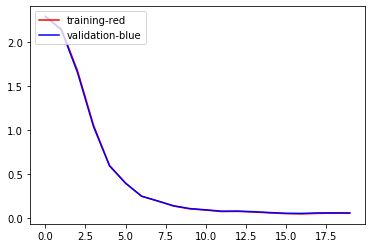

In [9]:
import sys
optim = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay = 1e-3) # weight decay is for l2 regularization
train(model,dataloaders,20,optim,3)

Πράγματι, παρατηρούμε ότι με τη συγκεκριμένη υλοποίηση το lstm εκπαιδεύεται αρκετά πιο γρήγορα περίπου 10 φορές ταχύτερα.